In [9]:
import pandas as pd, json
import numpy as np

# --- 0) Utilidades ---
def _is_dict(x): return isinstance(x, dict)
def _is_list(x): return isinstance(x, list)

def make_hashable(x):
    """Convierte list/dict a JSON ordenado para que sea comparable/hashable."""
    if isinstance(x, (list, dict)):
        return json.dumps(x, sort_keys=True, ensure_ascii=False)
    return x

def flatten_dict_columns(df):
    """Aplana columnas que contienen dict (una por una) con prefijo 'col.'"""
    dict_cols = [c for c in df.columns if df[c].apply(_is_dict).any()]
    for c in dict_cols:
        expanded = pd.json_normalize(df[c]).add_prefix(f"{c}.")
        df = df.drop(columns=[c]).join(expanded)
    return df

def strip_string_columns(df):
    """Quita espacios solo donde haya strings (sin romper listas/dicts)."""
    for c in df.columns:
        mask = df[c].apply(lambda v: isinstance(v, str))
        if mask.any():
            df.loc[mask, c] = df.loc[mask, c].str.strip()
    return df

# --- 1) Aplanar dicts y sanear espacios en textos ---
df = flatten_dict_columns(df)
df = strip_string_columns(df)

# --- 2) Duplicados (versión a prueba de dict/list) ---
df_hashable = df.applymap(make_hashable)
duplicados = df_hashable.duplicated().sum()
print(f"Duplicados (robusto): {duplicados}")

# Si quieres ver las filas duplicadas:
# dups_rows = df[df_hashable.duplicated(keep=False)]

# --- 3) Tipos de datos y conversión segura de numéricos comunes ---
print("\n=== Tipos de datos (antes) ===")
print(df.dtypes)

for col in ["TotalCharges", "MonthlyCharges", "Tenure"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("\n=== Tipos de datos (después) ===")
print(df.dtypes)

# --- 4) Niveles categóricos sin romper en columnas con dict/list ---
print("\n=== Niveles categóricos (robusto) ===")
for c in df.columns:
    # Consideramos 'categórico' cualquier columna object o category
    if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c]):
        # Convertimos list/dict a string estable para poder hacer unique()
        vals = df[c].dropna().map(make_hashable).astype(str)
        uniq = vals.unique()
        n = len(uniq)
        sample = uniq[:20]  # muestra hasta 20 niveles
        print(f"\n- {c}: {n} niveles. Muestra -> {list(sample)}")



Duplicados (robusto): 0

=== Tipos de datos (antes) ===
customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure                int64
phone.PhoneService            object
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection     object
internet.TechSupport          object
internet.StreamingTV          object
internet.StreamingMovies      object
account.Contract              object
account.PaperlessBilling      object
account.PaymentMethod         object
account.Charges.Monthly      float64
account.Charges.Total         object
dtype: object

=== Tipos de datos (después) ===
customerID                    object
Churn                         object
customer.gender               object
customer

/tmp/ipython-input-1504532330.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df.applymap(make_hashable)
/tmp/ipython-input-1504532330.py:57: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c]):
/tmp/ipython-input-1504532330.py:57: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c]):
/tmp/ipython-input-1504532330.py:57: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c]):


In [10]:
# Revisar estructura del DataFrame
print("=== Información del DataFrame ===")
print(df.info())

# Resumen estadístico para variables numéricas
print("\n=== Estadísticas descriptivas ===")
print(df.describe())

# Revisar columnas categóricas (primeras filas)
print("\n=== Primeras filas ===")
print(df.head(3))

=== Información del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechS

In [11]:
# Conteo de valores nulos por columna
print("=== Valores nulos ===")
print(df.isnull().sum())

# Revisar si hay espacios en blanco en columnas tipo texto
for col in df.select_dtypes(include="object").columns:
    if df[col].str.strip().eq("").any():
        print(f"⚠️ Columna con posibles vacíos en texto: {col}")


=== Valores nulos ===
customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64
⚠️ Columna con posibles vacíos en texto: Churn
⚠️ Columna con posibles vacíos en texto: account.Charges.Total


In [12]:
# Revisar registros duplicados
duplicados = df.duplicated().sum()
print(f"Cantidad de filas duplicadas: {duplicados}")


Cantidad de filas duplicadas: 0


In [13]:
# Revisar tipos de datos
print("\n=== Tipos de datos ===")
print(df.dtypes)

# Intentar convertir TotalCharges a numérico (muchas veces está en string)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

    # Revisar valores que no se pudieron convertir
    print("Valores nulos después de conversión en TotalCharges:", df["TotalCharges"].isnull().sum())



=== Tipos de datos ===
customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure                int64
phone.PhoneService            object
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection     object
internet.TechSupport          object
internet.StreamingTV          object
internet.StreamingMovies      object
account.Contract              object
account.PaperlessBilling      object
account.PaymentMethod         object
account.Charges.Monthly      float64
account.Charges.Total         object
dtype: object


In [14]:
# Revisar valores únicos en columnas categóricas
for col in df.select_dtypes(include="object").columns:
    print(f"\nColumna: {col}")
    print(df[col].unique())



Columna: customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Columna: Churn
['No' 'Yes' '']

Columna: customer.gender
['Female' 'Male']

Columna: customer.Partner
['Yes' 'No']

Columna: customer.Dependents
['Yes' 'No']

Columna: phone.PhoneService
['Yes' 'No']

Columna: phone.MultipleLines
['No' 'Yes' 'No phone service']

Columna: internet.InternetService
['DSL' 'Fiber optic' 'No']

Columna: internet.OnlineSecurity
['No' 'Yes' 'No internet service']

Columna: internet.OnlineBackup
['Yes' 'No' 'No internet service']

Columna: internet.DeviceProtection
['No' 'Yes' 'No internet service']

Columna: internet.TechSupport
['Yes' 'No' 'No internet service']

Columna: internet.StreamingTV
['Yes' 'No' 'No internet service']

Columna: internet.StreamingMovies
['No' 'Yes' 'No internet service']

Columna: account.Contract
['One year' 'Month-to-month' 'Two year']

Columna: account.PaperlessBilling
['Yes' 'No']

Columna: account.PaymentMethod
['Mailed che

In [15]:
import pandas as pd
import numpy as np

# --- 1) Eliminar duplicados ---
df = df.drop_duplicates().reset_index(drop=True)

# --- 2) Corregir columnas numéricas ---
# TotalCharges suele venir como texto con espacios -> convertir a numérico
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Rellenar nulos en TotalCharges (ej: clientes recién contratados con tenure=0)
if "Tenure" in df.columns and "TotalCharges" in df.columns:
    df.loc[df["TotalCharges"].isnull() & (df["Tenure"] == 0), "TotalCharges"] = 0

# --- 3) Rellenar valores nulos ---
# Numéricas → con la mediana (menos sensible a outliers)
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Categóricas → con la moda (valor más frecuente)
for col in df.select_dtypes(include="object").columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# --- 4) Normalizar categorías ---
def clean_category(x):
    if isinstance(x, str):
        return x.strip().title()   # quita espacios y pone mayúscula inicial
    return x

for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].map(clean_category)

# Ajustar "Yes/No" → binarios
yes_no_cols = [c for c in df.columns if df[c].isin(["Yes","No"]).all()]
for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

# --- 5) Verificación final ---
print("=== Datos limpios ===")
print(df.info())
print("\nNulos por columna:\n", df.isnull().sum().sort_values(ascending=False).head())
print("\nEjemplo de filas:\n", df.head(3))


=== Datos limpios ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   int64  
 5   customer.Dependents        7267 non-null   int64  
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   int64  
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport      

In [18]:
# Crear la nueva columna a partir de la facturación mensual real
df["Cuentas_Diarias"] = df["account.Charges.Monthly"] / 30

# Verificar
print(df[["account.Charges.Monthly", "Cuentas_Diarias"]].head())



   account.Charges.Monthly  Cuentas_Diarias
0                     65.6         2.186667
1                     59.9         1.996667
2                     73.9         2.463333
3                     98.0         3.266667
4                     83.9         2.796667


In [19]:
# --- 1) Copia de seguridad del DataFrame ---
df_clean = df.copy()

# --- 2) Convertir valores "Yes/No" y "Sí/No" en 1 y 0 ---
# Detecta automáticamente columnas binarias
for col in df_clean.select_dtypes(include="object").columns:
    uniques = df_clean[col].dropna().unique()
    if set(uniques).issubset({"Yes", "No", "Sí", "No", "si", "no"}):
        df_clean[col] = df_clean[col].replace(
            {"Yes": 1, "No": 0, "Sí": 1, "No": 0, "si": 1, "no": 0}
        )

# --- 3) Renombrar columnas para mayor claridad ---
df_clean.rename(columns={
    "customer.gender": "Genero",
    "customer.SeniorCitizen": "Adulto_Mayor",
    "customer.Partner": "Pareja",
    "customer.Dependents": "Dependientes",
    "customer.tenure": "Meses_Cliente",
    "phone.PhoneService": "Servicio_Telefono",
    "phone.MultipleLines": "Lineas_Multiples",
    "internet.InternetService": "Servicio_Internet",
    "internet.OnlineSecurity": "Seguridad_Online",
    "internet.OnlineBackup": "Respaldo_Online",
    "internet.DeviceProtection": "Proteccion_Dispositivo",
    "internet.TechSupport": "Soporte_Tecnico",
    "internet.StreamingTV": "Streaming_TV",
    "internet.StreamingMovies": "Streaming_Peliculas",
    "account.Contract": "Tipo_Contrato",
    "account.PaperlessBilling": "Facturacion_Electronica",
    "account.PaymentMethod": "Metodo_Pago",
    "account.Charges.Monthly": "Cargos_Mensuales",
    "account.Charges.Total": "Cargos_Totales",
    "Cuentas_Diarias": "Cargos_Diarios"
}, inplace=True)

# --- 4) Revisión final ---
print(df_clean.head(3))
print("\nNombres de columnas:", df_clean.columns.tolist())


   customerID Churn  Genero  Adulto_Mayor  Pareja  Dependientes  \
0  0002-Orfbo    No  Female             0       1             1   
1  0003-Mknfe    No    Male             0       0             0   
2  0004-Tlhlj   Yes    Male             0       0             0   

   Meses_Cliente  Servicio_Telefono Lineas_Multiples Servicio_Internet  ...  \
0              9                  1               No               Dsl  ...   
1              9                  1              Yes               Dsl  ...   
2              4                  1               No       Fiber Optic  ...   

  Proteccion_Dispositivo Soporte_Tecnico Streaming_TV Streaming_Peliculas  \
0                     No             Yes          Yes                  No   
1                     No              No           No                 Yes   
2                    Yes              No           No                  No   

    Tipo_Contrato Facturacion_Electronica       Metodo_Pago  Cargos_Mensuales  \
0        One Year       

In [23]:
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Opcional: rellenar NaN con la mediana
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Verificar tipos
print(df_clean[num_cols].dtypes)
print(df_clean[num_cols].head())

Meses_Cliente         int64
Cargos_Mensuales    float64
Cargos_Totales      float64
Cargos_Diarios      float64
dtype: object
   Meses_Cliente  Cargos_Mensuales  Cargos_Totales  Cargos_Diarios
0              9              65.6          593.30        2.186667
1              9              59.9          542.40        1.996667
2              4              73.9          280.85        2.463333
3             13              98.0         1237.85        3.266667
4              3              83.9          267.40        2.796667


In [24]:
# Descripción de columnas numéricas
desc_num = df_clean[num_cols].describe().T
desc_num["mediana"] = df_clean[num_cols].median()
desc_num["rango"] = desc_num["max"] - desc_num["min"]
desc_num["varianza"] = df_clean[num_cols].var()
print(desc_num)


                   count         mean          std        min         25%  \
Meses_Cliente     7267.0    32.346498    24.571773   0.000000    9.000000   
Cargos_Mensuales  7267.0    64.720098    30.129572  18.250000   35.425000   
Cargos_Totales    7267.0  2279.287581  2267.178963  18.800000  401.400000   
Cargos_Diarios    7267.0     2.157337     1.004319   0.608333    1.180833   

                          50%          75%          max      mediana    rango  \
Meses_Cliente       29.000000    55.000000    72.000000    29.000000    72.00   
Cargos_Mensuales    70.300000    89.875000   118.750000    70.300000   100.50   
Cargos_Totales    1391.000000  3778.525000  8684.800000  1391.000000  8666.00   
Cargos_Diarios       2.343333     2.995833     3.958333     2.343333     3.35   

                      varianza  
Meses_Cliente     6.037720e+02  
Cargos_Mensuales  9.077911e+02  
Cargos_Totales    5.140100e+06  
Cargos_Diarios    1.008657e+00  


Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64


/tmp/ipython-input-1339214109.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="Set2")


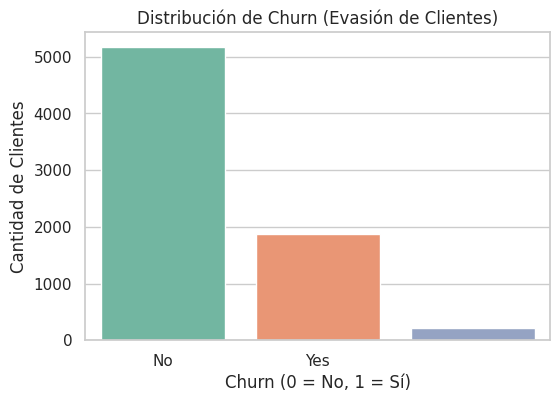

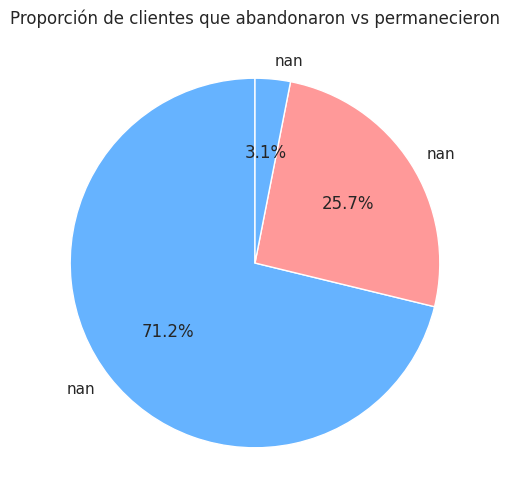

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")

# --- 1) Conteo de clientes por Churn ---
churn_counts = df_clean["Churn"].value_counts()
print(churn_counts)

# --- 2) Gráfico de barras ---
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="Set2")
plt.title("Distribución de Churn (Evasión de Clientes)")
plt.xlabel("Churn (0 = No, 1 = Sí)")
plt.ylabel("Cantidad de Clientes")
plt.show()

# --- 3) Gráfico de pastel ---
plt.figure(figsize=(6,6))
plt.pie(churn_counts.values, labels=churn_counts.index.map({0:"No", 1:"Sí"}),
        autopct="%1.1f%%", colors=["#66b3ff","#ff9999"], startangle=90)
plt.title("Proporción de clientes que abandonaron vs permanecieron")
plt.show()


In [27]:
# Convertir Churn a 0 y 1
df_clean["Churn"] = df_clean["Churn"].replace({"Yes": 1, "No": 0, "Sí": 1, "No": 0})

# Verificar
print(df_clean["Churn"].value_counts())



Churn
0    5174
1    1869
      224
Name: count, dtype: int64


In [29]:
# Quitar espacios y convertir a mayúscula para estandarizar
df_clean["Churn"] = df_clean["Churn"].astype(str).str.strip().str.upper()

# Mapear a 0 y 1
df_clean["Churn"] = df_clean["Churn"].replace({"YES": 1, "SÍ": 1, "SI": 1, "NO": 0})

# Convertir finalmente a numérico
df_clean["Churn"] = pd.to_numeric(df_clean["Churn"], errors="coerce")

# Verificar que no haya nulos
print(df_clean["Churn"].value_counts(dropna=False))


Churn
0.0    5174
1.0    1869
NaN     224
Name: count, dtype: int64


In [31]:
df_clean = df_clean[df_clean["Churn"].notnull()]


/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


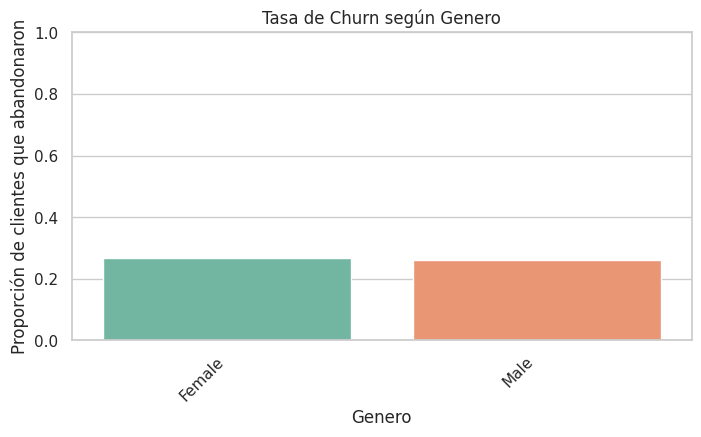

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


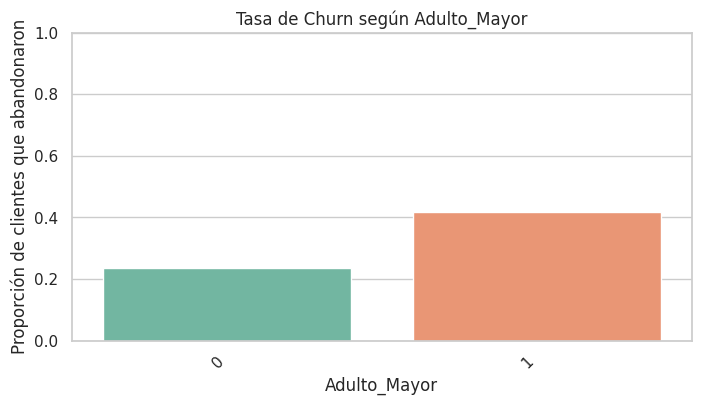

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


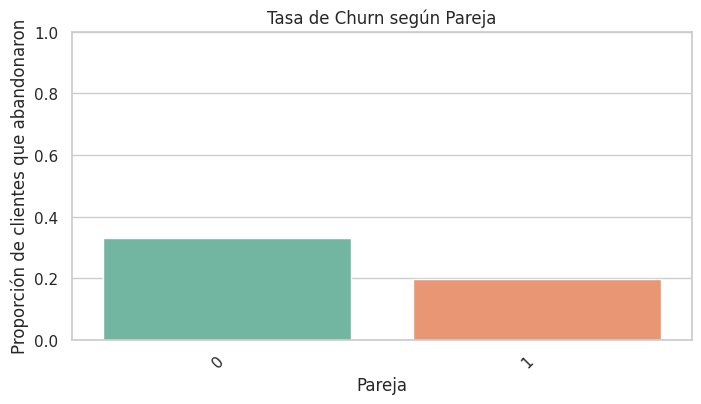

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


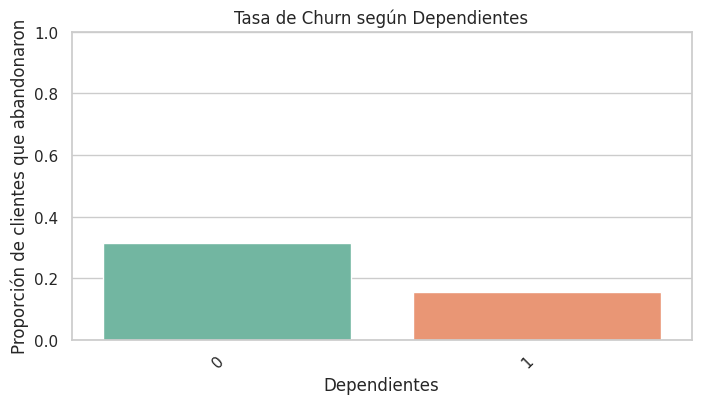

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


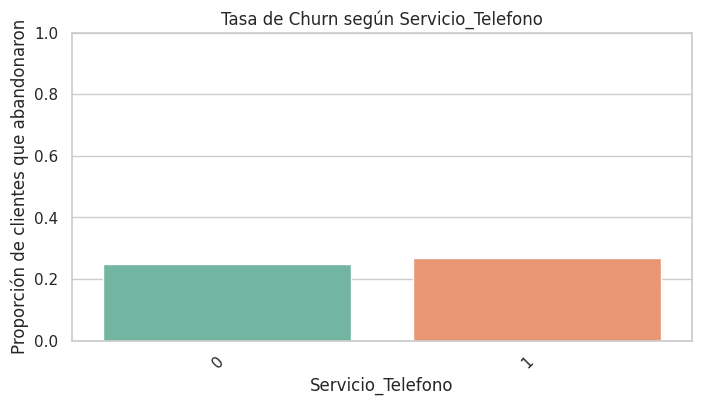

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


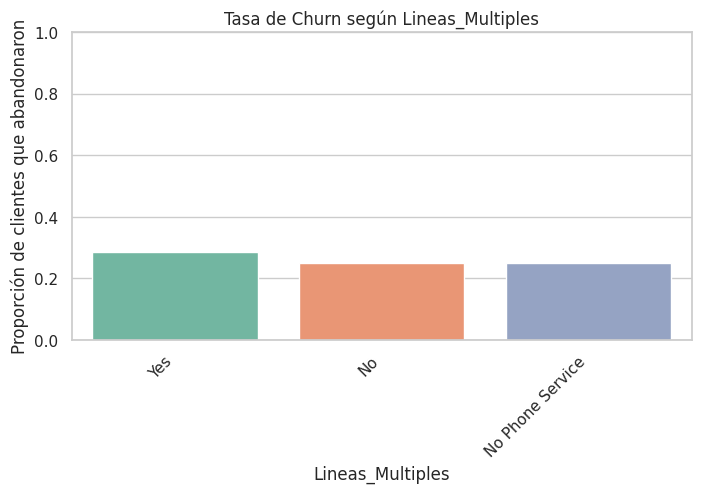

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


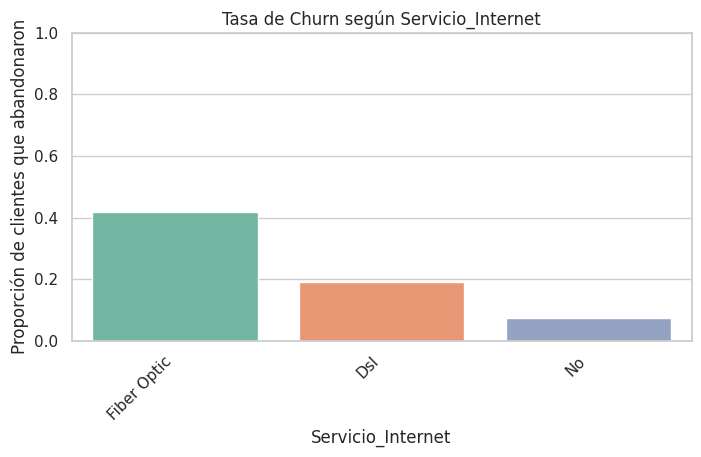

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


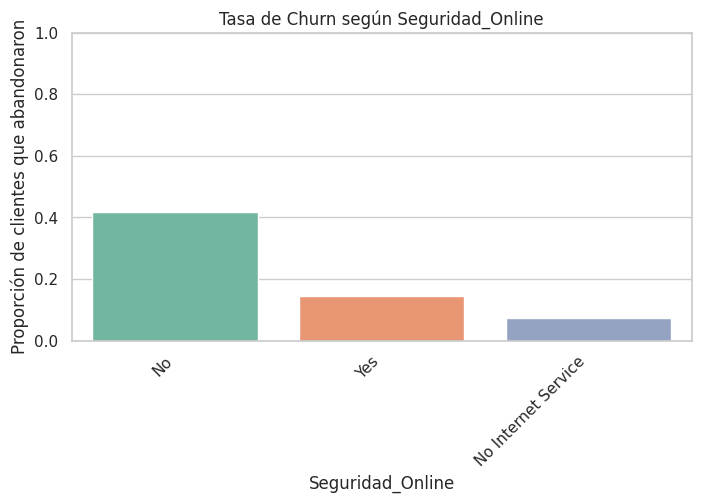

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


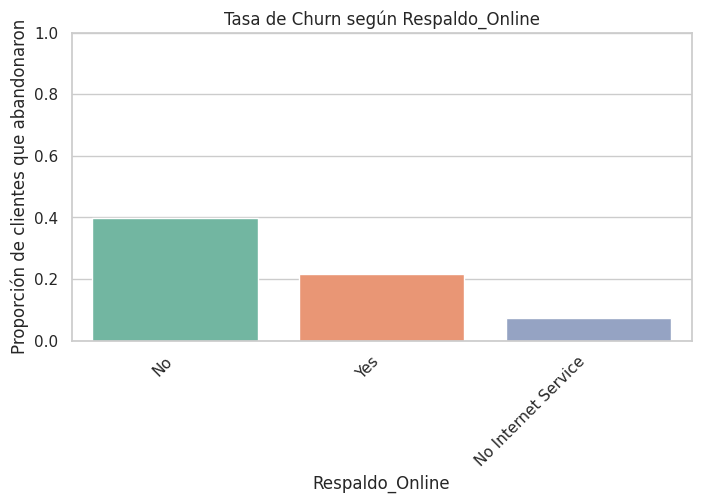

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


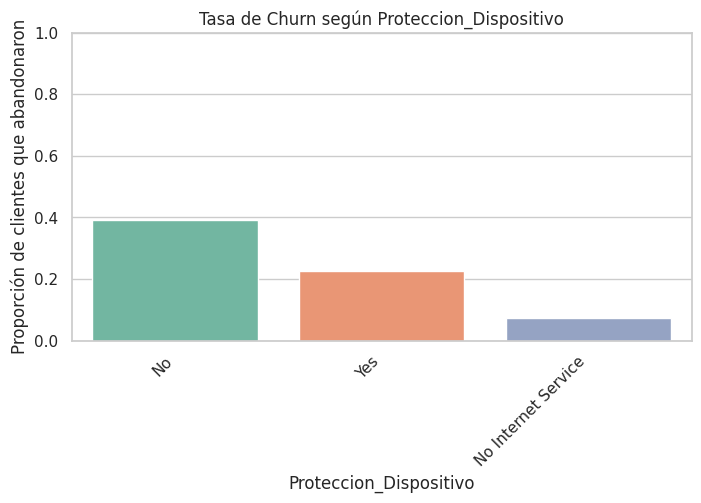

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


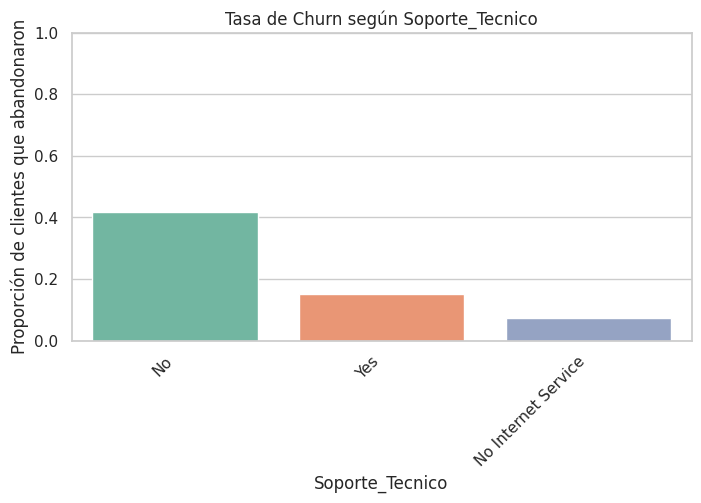

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


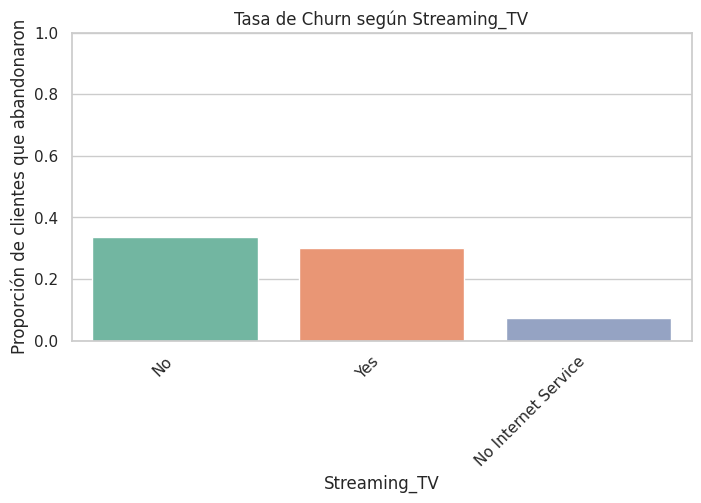

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


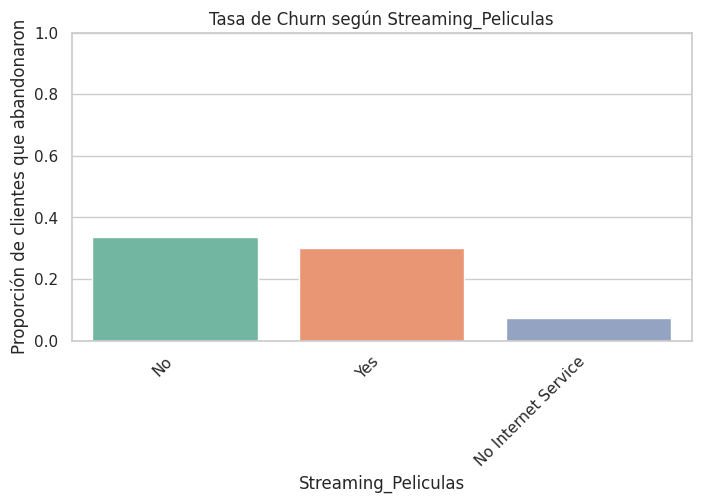

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


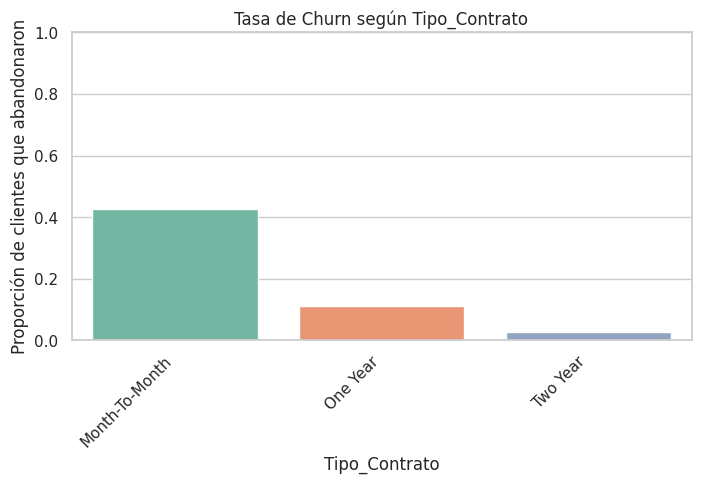

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


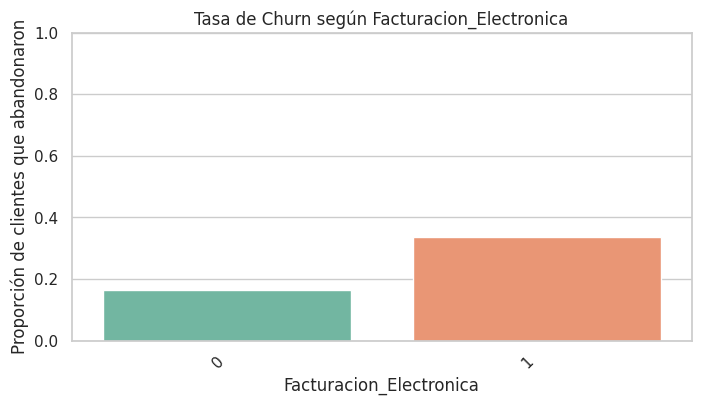

/tmp/ipython-input-3711863237.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


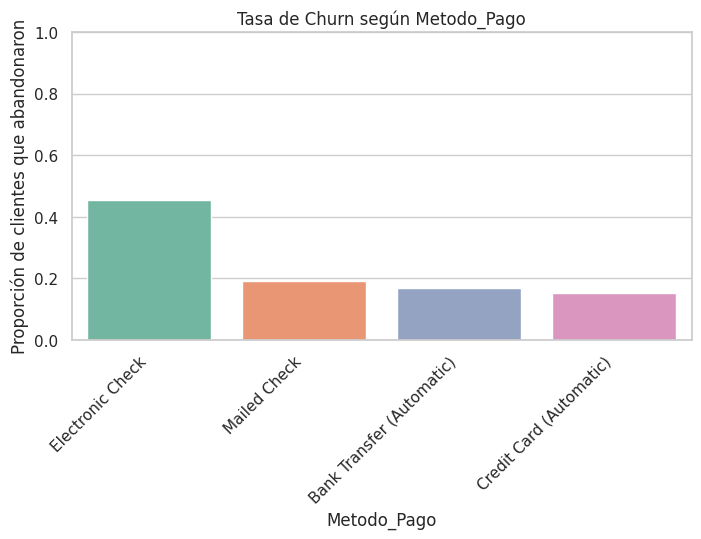

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

categorical_cols = [
    "Genero", "Adulto_Mayor", "Pareja", "Dependientes",
    "Servicio_Telefono", "Lineas_Multiples", "Servicio_Internet",
    "Seguridad_Online", "Respaldo_Online", "Proteccion_Dispositivo",
    "Soporte_Tecnico", "Streaming_TV", "Streaming_Peliculas",
    "Tipo_Contrato", "Facturacion_Electronica", "Metodo_Pago"
]

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    # Proporción de Churn por categoría
    prop = df_clean.groupby(col)["Churn"].mean().sort_values(ascending=False)
    sns.barplot(x=prop.index, y=prop.values, palette="Set2")
    plt.title(f"Tasa de Churn según {col}")
    plt.ylabel("Proporción de clientes que abandonaron")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0,1)
    plt.show()


/tmp/ipython-input-2767814095.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


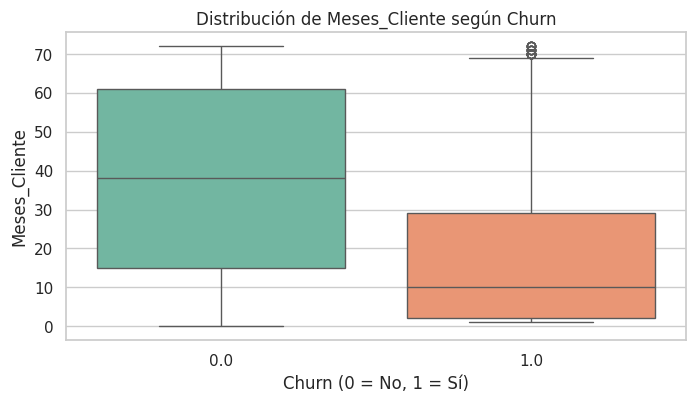

/tmp/ipython-input-2767814095.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


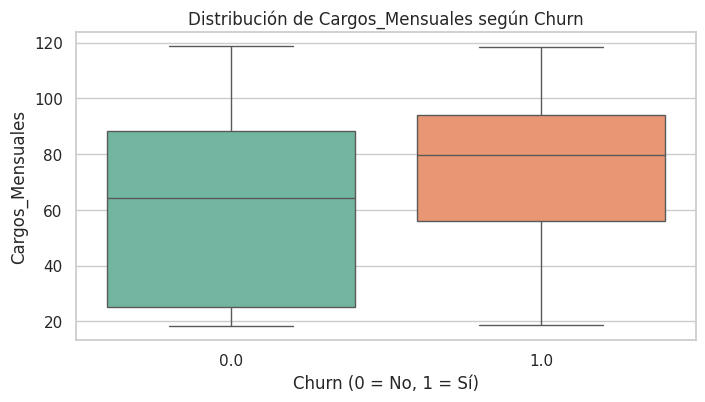

/tmp/ipython-input-2767814095.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


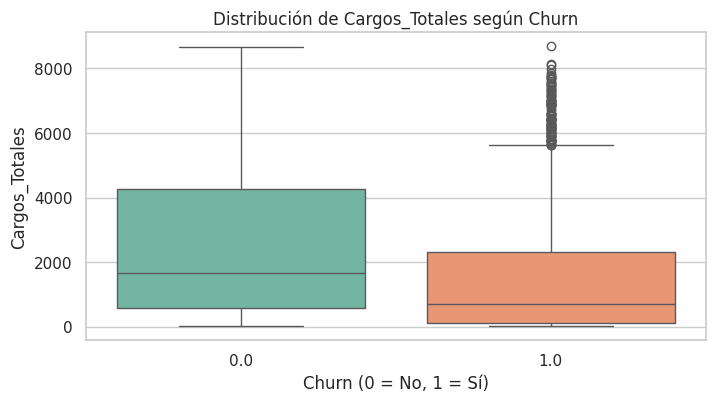

/tmp/ipython-input-2767814095.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


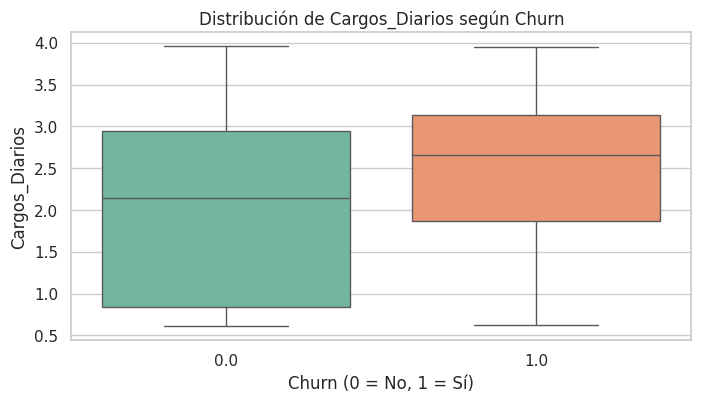

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Variables numéricas de interés
num_cols = ["Meses_Cliente", "Cargos_Mensuales", "Cargos_Totales", "Cargos_Diarios"]

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")
    plt.title(f"Distribución de {col} según Churn")
    plt.xlabel("Churn (0 = No, 1 = Sí)")
    plt.ylabel(col)
    plt.show()


/tmp/ipython-input-2049582951.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="Set2")


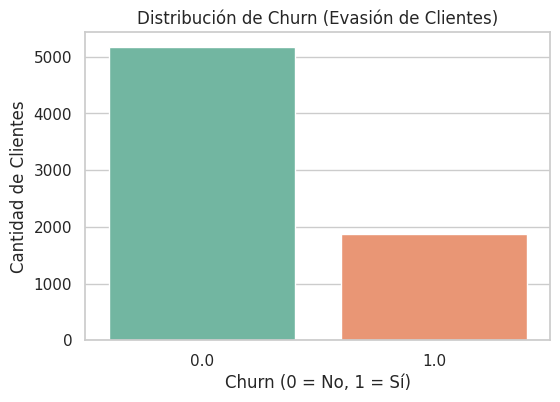

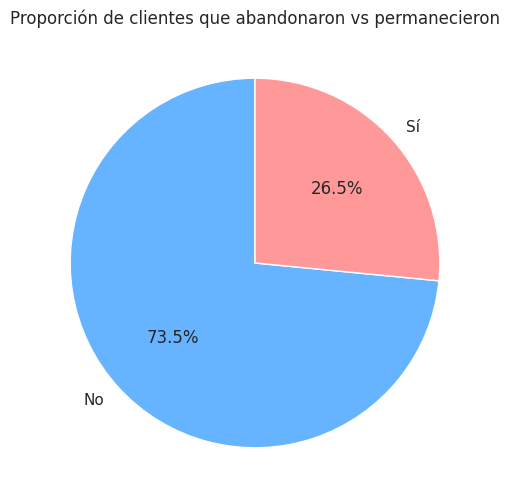

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

churn_counts = df_clean["Churn"].value_counts()

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="Set2")
plt.title("Distribución de Churn (Evasión de Clientes)")
plt.xlabel("Churn (0 = No, 1 = Sí)")
plt.ylabel("Cantidad de Clientes")
plt.show()

# Gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(churn_counts.values, labels=["No","Sí"], autopct="%1.1f%%", colors=["#66b3ff","#ff9999"], startangle=90)
plt.title("Proporción de clientes que abandonaron vs permanecieron")
plt.show()


/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


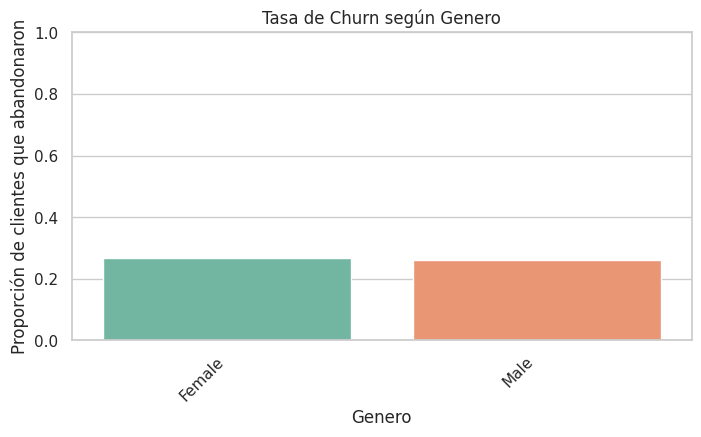

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


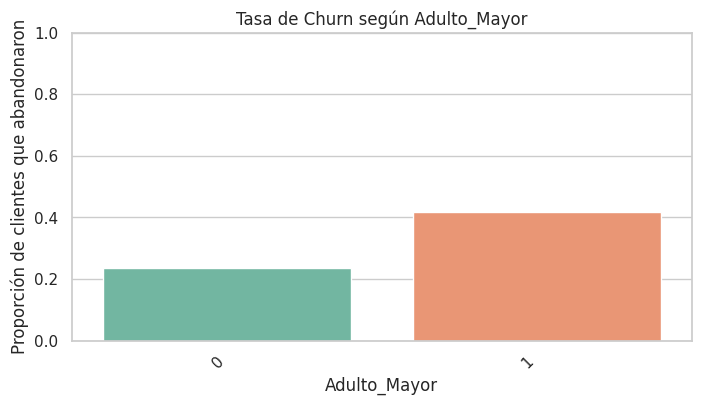

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


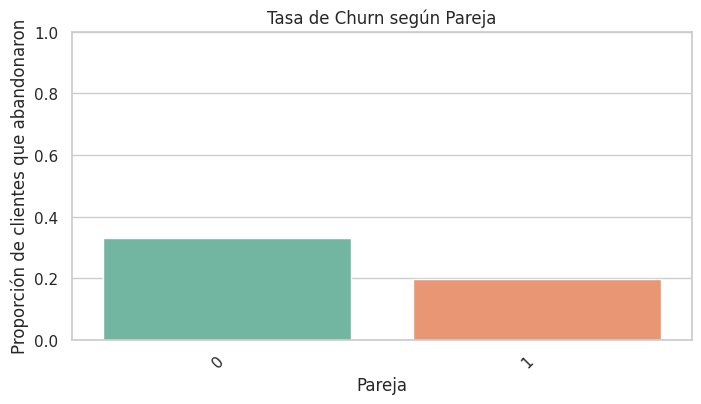

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


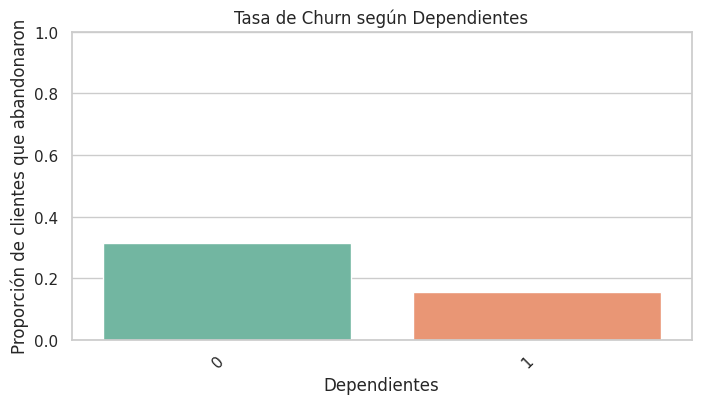

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


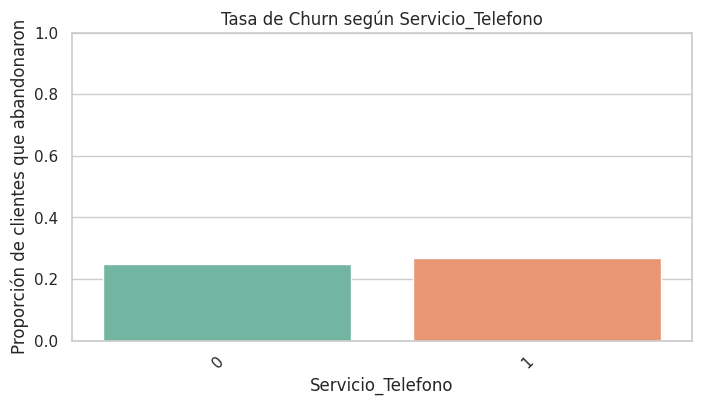

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


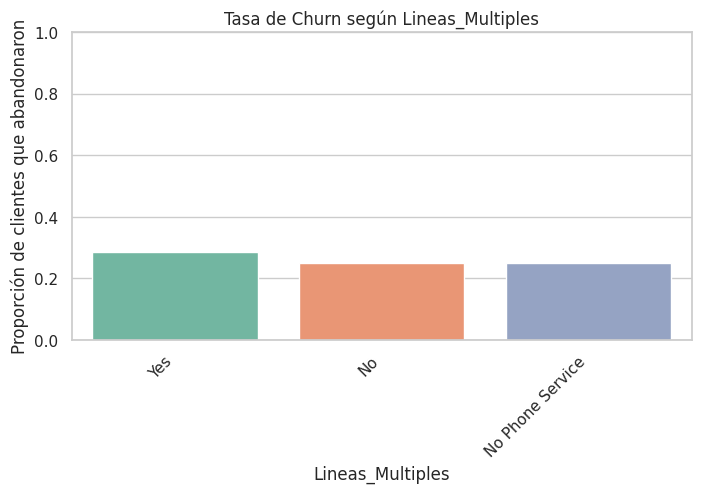

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


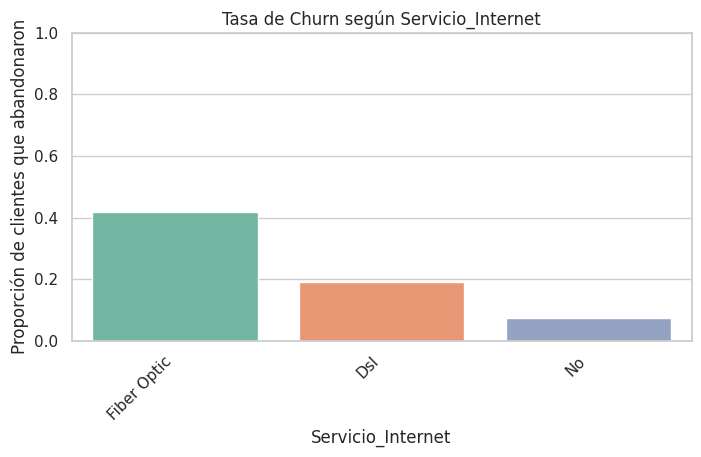

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


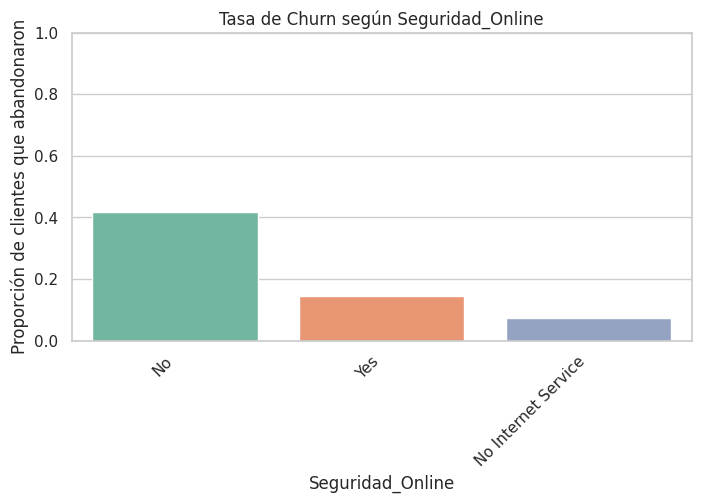

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


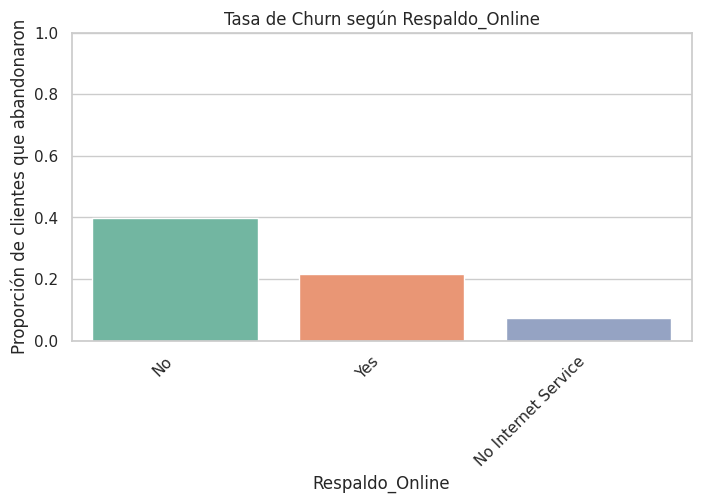

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


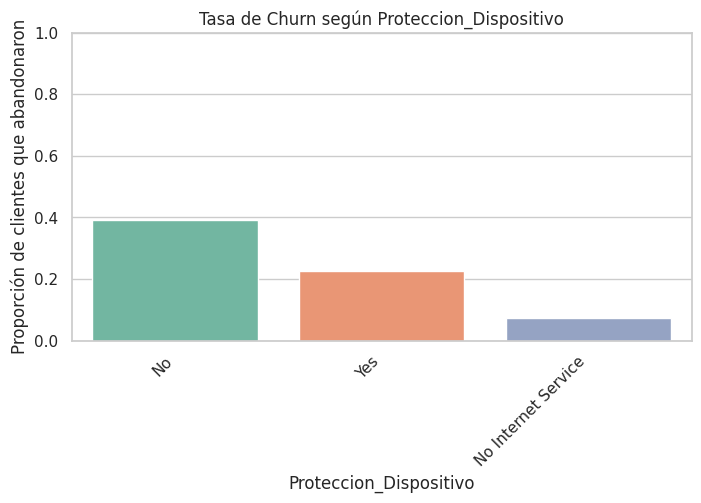

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


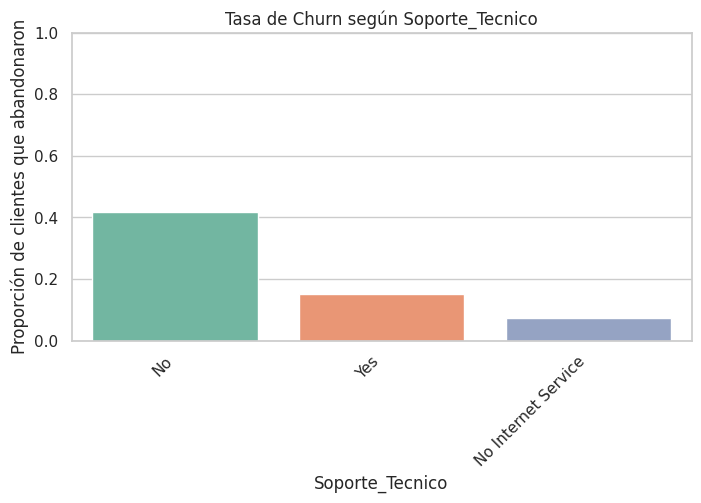

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


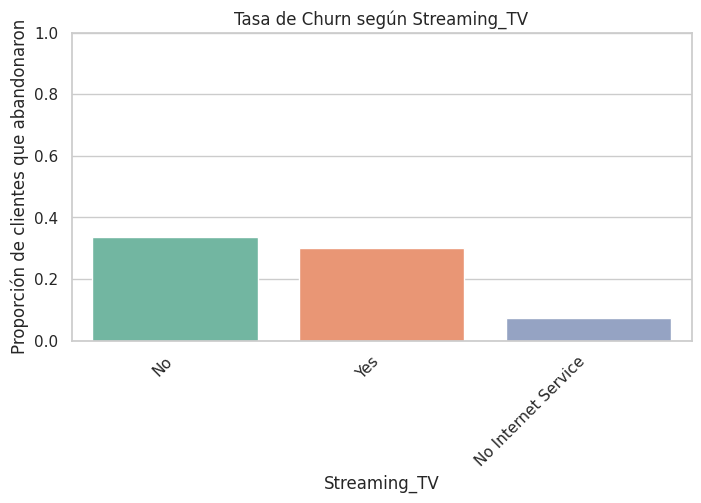

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


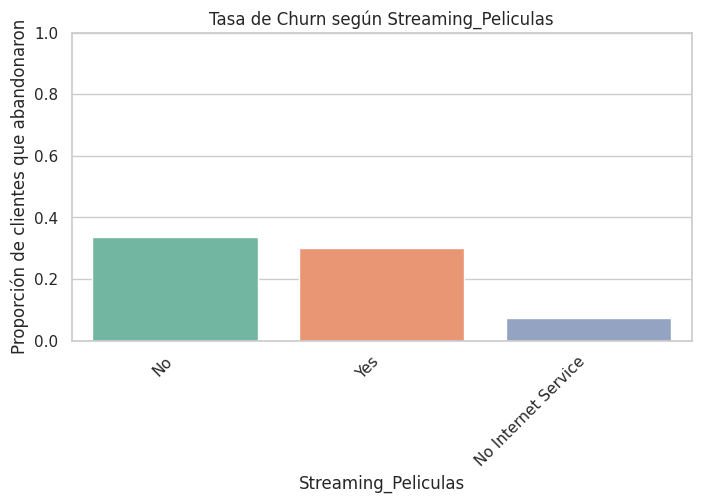

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


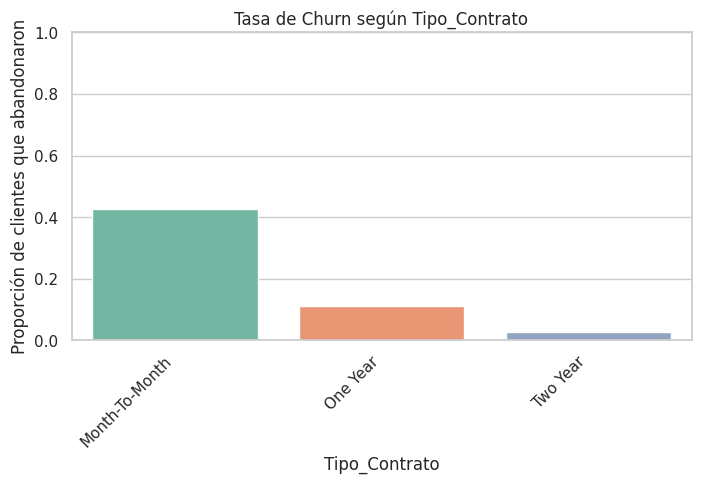

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


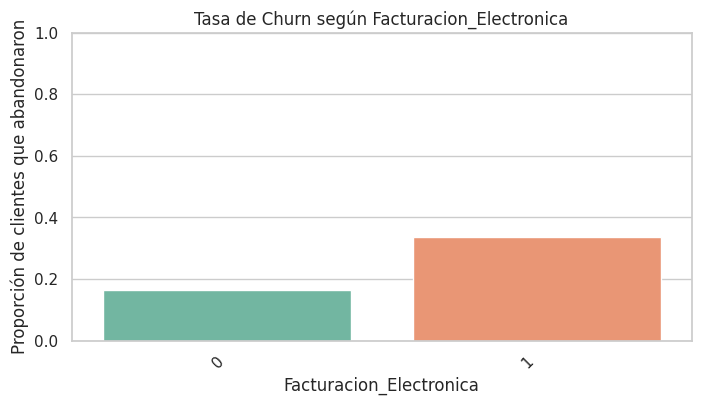

/tmp/ipython-input-151994106.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette="Set2")


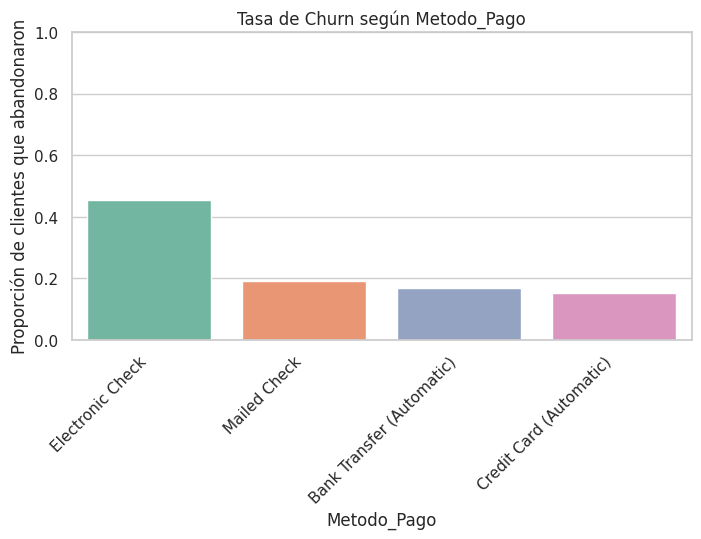

In [35]:
categorical_cols = [
    "Genero", "Adulto_Mayor", "Pareja", "Dependientes",
    "Servicio_Telefono", "Lineas_Multiples", "Servicio_Internet",
    "Seguridad_Online", "Respaldo_Online", "Proteccion_Dispositivo",
    "Soporte_Tecnico", "Streaming_TV", "Streaming_Peliculas",
    "Tipo_Contrato", "Facturacion_Electronica", "Metodo_Pago"
]

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    prop = df_clean.groupby(col)["Churn"].mean().sort_values(ascending=False)
    sns.barplot(x=prop.index, y=prop.values, palette="Set2")
    plt.title(f"Tasa de Churn según {col}")
    plt.ylabel("Proporción de clientes que abandonaron")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0,1)
    plt.show()


/tmp/ipython-input-820198022.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


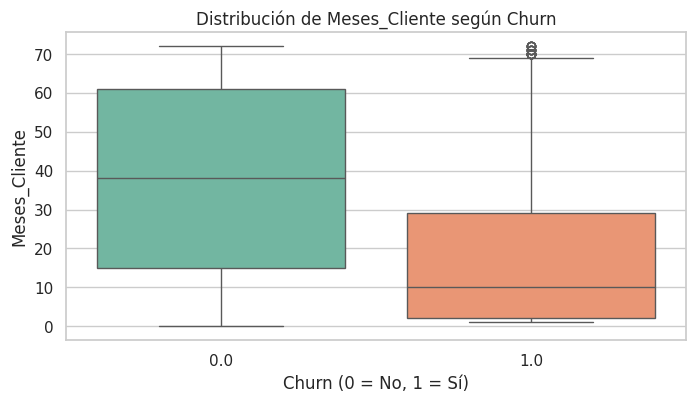

/tmp/ipython-input-820198022.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


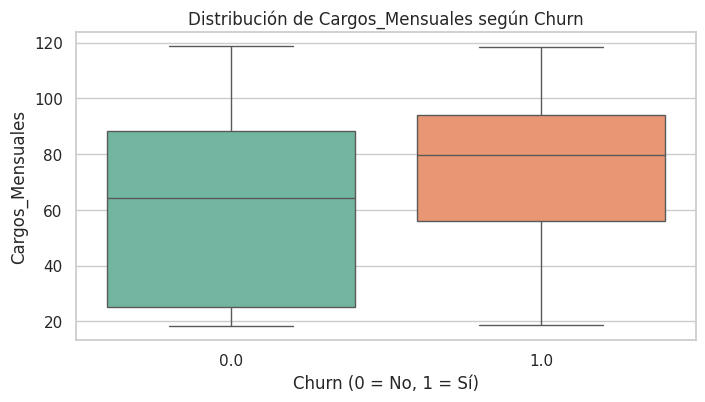

/tmp/ipython-input-820198022.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


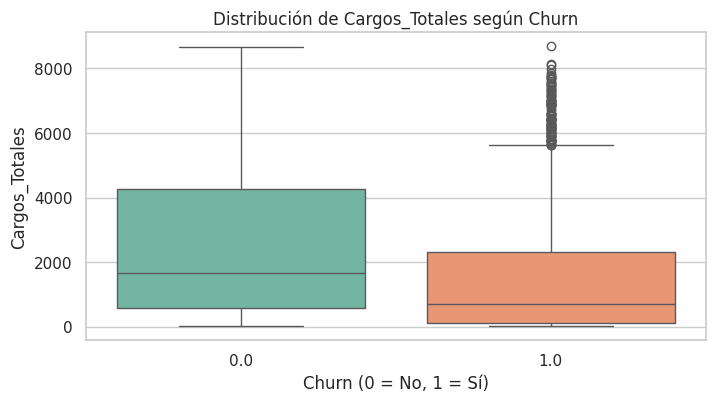

/tmp/ipython-input-820198022.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")


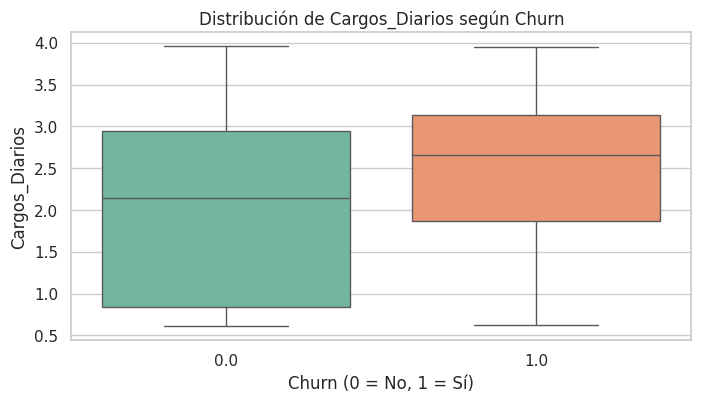

In [36]:
num_cols = ["Meses_Cliente", "Cargos_Mensuales", "Cargos_Totales", "Cargos_Diarios"]

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="Churn", y=col, data=df_clean, palette="Set2")
    plt.title(f"Distribución de {col} según Churn")
    plt.xlabel("Churn (0 = No, 1 = Sí)")
    plt.ylabel(col)
    plt.show()
